# Introduction

this code is trying to classify movie reviews by using Bert Word Embeddings that then be passed into a CNN.




# install and import

In [ ]:
pip install transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
import torch
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.models import Word2Vec
import gensim
from tqdm import tqdm
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from collections import Counter
from sklearn.metrics import accuracy_score

import torch
from transformers import BertTokenizer
from transformers import BertModel


from collections import Counter
from sklearn.metrics import accuracy_score



from transformers import AdamW
import pickle

In [ ]:
# specify GPU
device = torch.device("cuda")
print(device)

cuda


# Load Data

In [ ]:
df = pd.read_csv("movie_review_RT50K.csv")
print(df.shape)
df.head(3)

(50000, 2)


,content,sentiment
0,"Compelling in fits and starts, actor-director ...",0
1,Quite simply one of the finest comic romances ...,1
2,A psychological thriller that dangles over the...,0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['content'], 
                                                    df['sentiment'], 
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=2021)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(40000,)
(40000,)
(10000,)
(10000,)


In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                    Y_train, 
                                                    shuffle=True,
                                                    test_size=0.1, 
                                                    random_state=2021)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(36000,)
(36000,)
(4000,)
(4000,)


# Get the bert tokenization id for each sentence

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# tokenize and encode the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = 50,
    truncation=True,
    padding='max_length',
)

# tokenize and encode the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_valid.tolist(),
    max_length = 50,
    truncation=True,
    padding='max_length',
)

# tokenize and encode the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = 50,
    truncation=True,
    padding='max_length',
)

In [ ]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(Y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(Y_valid.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(Y_test.tolist())

In [ ]:
for p in tokenizer.convert_ids_to_tokens(train_seq[0]):
  print(p, end=' ')


[CLS] one of the best horror films ever made . john carpenter deserves a medal for his effective build - up of suspense , his kn ##ack for casting and his sensation ##ally - scary michael myers ! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

# From Bert TokenID to get Bert Word Embeddings

we get the word embedding by summing the last 4 layers from bert hidden output, this is a contexualized word embeddings by using attention mask

an example of a batch of 10 examples

**freeze all bert layers from updating gradient**

In [ ]:
for param in bert.parameters():
  param.requires_grad = False

In [ ]:
tempTrain=train_seq[:10]
tempTrainAtt=train_mask[:10]
bert.eval()

with torch.no_grad():

    outputs = bert(tempTrain,tempTrainAtt)

    hidden_states = outputs['hidden_states']
    # print(hidden_states[-4:][0].shape) #torch.Size([10, 50, 768])
    # print(torch.stack(hidden_states[-4:]).shape)#torch.Size([4, 10, 50, 768])    
    # sum of last four layer
    Last4Summed = torch.stack(hidden_states[-4:]).sum(0)
    print('L4',Last4Summed.shape)          

L4 torch.Size([10, 50, 768])


# (dont run this, this can not be done, because ram is not big enough, have to manually calculate each time) get word embeddings to cpu, don't need to convert everytime during training, because we are not propogating back the gradient

In [ ]:
# # train_Em,test_Em,val_Em
# for param in bert.parameters():
#   param.requires_grad = False

In [ ]:
# bert.to(device)

# def getBertEmbeddings(seq,attention):
#   BATCH_SIZE=200
#   bert.eval()
#   res=torch.tensor([])
#   with torch.no_grad():
#     for i in tqdm(range(0,len(seq),BATCH_SIZE)):

#       endIndex=min(i+BATCH_SIZE,len(seq))
#       sent_id= seq[i:endIndex].to(device)
#       mask   = attention[i:endIndex].to(device)
#       output=bert(sent_id,mask)
#       hidden_states = output['hidden_states']
#       Last4Summed = torch.stack(hidden_states[-4:]).sum(0).cpu() 
#       res=torch.cat((res,Last4Summed),dim=0)

#   return res


In [ ]:
# train_Em=getBertEmbeddings(train_seq,train_mask)
# test_Em=getBertEmbeddings(test_seq,test_mask)
# val_Em=getBertEmbeddings(val_seq,val_mask)

# print()
# print(train_Em.shape)
# print(test_Em.shape)
# print(val_Em.shape)




  0%|          | 0/180 [00:00<?, ?it/s]


  1%|          | 1/180 [00:00<00:32,  5.42it/s]


  1%|          | 2/180 [00:00<00:33,  5.34it/s]


  2%|▏         | 3/180 [00:00<00:33,  5.32it/s]


  2%|▏         | 4/180 [00:00<00:33,  5.24it/s]


  3%|▎         | 5/180 [00:01<00:36,  4.74it/s]


  3%|▎         | 6/180 [00:01<00:37,  4.69it/s]


  4%|▍         | 7/180 [00:01<00:38,  4.49it/s]


  4%|▍         | 8/180 [00:01<00:43,  3.98it/s]


  5%|▌         | 9/180 [00:02<00:46,  3.67it/s]


  6%|▌         | 10/180 [00:02<00:50,  3.39it/s]


  6%|▌         | 11/180 [00:02<00:48,  3.46it/s]


  7%|▋         | 12/180 [00:03<00:46,  3.58it/s]


  7%|▋         | 13/180 [00:03<00:51,  3.21it/s]


  8%|▊         | 14/180 [00:03<00:56,  2.95it/s]


  8%|▊         | 15/180 [00:04<00:53,  3.08it/s]


  9%|▉         | 16/180 [00:04<00:51,  3.19it/s]


  9%|▉         | 17/180 [00:04<00:50,  3.24it/s]


 10%|█         | 18/180 [00:05<00:53,  3.04it/s]


 11%|█         | 19/180 [00:05<00:52,  3.07it/

# Classifier

In [ ]:
NUM_CLASSES = 2
EMBEDDING_SIZE = 768 #bert embedding length
NUM_FILTERS = 10


class CNN_BertEm(nn.Module):

    def __init__(self, bert,  window_sizes=(1,2,3,5)):

        super(CNN_BertEm, self).__init__() 
        #Bert 
        self.bert=bert

        #CNN                
        self.convs = nn.ModuleList([
              nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
              for window_size in window_sizes
        ])

        self.relu =  nn.ReLU()        
        self.fc1=nn.Linear(NUM_FILTERS * len(window_sizes),100 )
        self.fc2 = nn.Linear(100, 2)
        self.bn = nn.BatchNorm1d(num_features=100)
        self.dropout= nn.Dropout(0.2)
        


    def forward(self, sent_id, attention_mask):

        outputs = bert(sent_id,attention_mask)
        hidden_states = outputs['hidden_states']
        x = torch.stack(hidden_states[-4:]).sum(0)
        # print(x.shape)#torch.Size([1, 50, 768])

        x = torch.unsqueeze(x, 1)
        # print('before CNN',x.shape)#before CNN torch.Size([1, 1, 50, 768])
        #CNN

        xs = []
        for conv in self.convs:
            x2=conv(x)
            x2 = torch.tanh(x2)
            x2 = torch.squeeze(x2, -1)          #you can only squeeze if you know for sure that dimension is 1
            x2 = F.max_pool1d(x2, x2.size(2))   #max_pool1d can only take in 3 dimensional data, thats why you need to squeeze
            xs.append(x2)

        x = torch.cat(xs, 2)        
        x = x.view(x.size(0), -1) #only keep the batch ,(1,40)


        # Feed Forward layer
        x=self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        res = F.softmax(x, dim = 1)

        return res


# tseq=train_seq[0].view(-1,50)
# tmask=train_mask[0].view(-1,50)
# model=CNN_BertEm(bert)
# model(tseq,tmask)

# Training

In [ ]:
trainLen=len(train_seq)
testLen=len(test_seq)
validLen=len(val_seq)


In [ ]:
for param in bert.parameters():
  param.requires_grad = False

In [ ]:

def getValid():
  
  model.eval()
  with torch.no_grad():
    
    BATCH_SIZE=200
    temp_pred=[]
    validLoss=0

    for i in range(0,validLen,BATCH_SIZE):
      
      endIndex=min(i+BATCH_SIZE,validLen)


      sent_id= val_seq[i:endIndex].to(device)
      mask   = val_mask[i:endIndex].to(device)
      labels = val_y[i:endIndex].to(device)   

      output=model(sent_id, mask)   
           

      predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
      temp_pred.extend(predicted_class) 

      
      loss = loss_function(output, labels)


      validLoss += loss.item()


    validLoss=round(validLoss /validLen,5)
    validAcc=round(accuracy_score(Y_valid.tolist(), temp_pred),3)

  return validLoss,validAcc




In [ ]:
%%time

BATCH_SIZE=100

model=CNN_BertEm(bert)
model.to(device)


# model(tseq,tmask)


optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=10

train_loss=[]
val_loss=[]
val_acc=[]

model.train()   #to speicify the training condition


for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'started')
    trainLoss = 0

    
    for i in tqdm(range(0,trainLen,BATCH_SIZE)):

        
        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,trainLen)


        sent_id= train_seq[i:endIndex].to(device)
        mask   = train_mask[i:endIndex].to(device)
        labels = train_y[i:endIndex].to(device)    
        
        output=model(sent_id, mask)

        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    

    trainLoss=round(trainLoss / trainLen,5)
    validLoss,validAcc=getValid()


    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)       

    model.train()  
    
    print('train loss',trainLoss) 
    print()


  1%|          | 2/360 [00:00<00:34, 10.45it/s]

Epoch1 started


  1%|          | 2/360 [00:00<00:32, 11.14it/s]

train loss 0.00571

Epoch2 started


  1%|          | 2/360 [00:00<00:32, 11.01it/s]

train loss 0.00495

Epoch3 started


  1%|          | 2/360 [00:00<00:32, 11.12it/s]

train loss 0.00481

Epoch4 started


  1%|          | 2/360 [00:00<00:32, 10.86it/s]

train loss 0.00473

Epoch5 started


  1%|          | 2/360 [00:00<00:32, 11.15it/s]

train loss 0.00468

Epoch6 started


  1%|          | 2/360 [00:00<00:33, 10.68it/s]

train loss 0.00459

Epoch7 started


  1%|          | 2/360 [00:00<00:32, 11.02it/s]

train loss 0.00455

Epoch8 started


  1%|          | 2/360 [00:00<00:32, 10.92it/s]

train loss 0.00448

Epoch9 started


  1%|          | 2/360 [00:00<00:32, 10.90it/s]

train loss 0.00443

Epoch10 started


100%|██████████| 360/360 [00:32<00:00, 10.95it/s]


train loss 0.00439

CPU times: user 5min 50s, sys: 3.17 s, total: 5min 53s
Wall time: 5min 57s


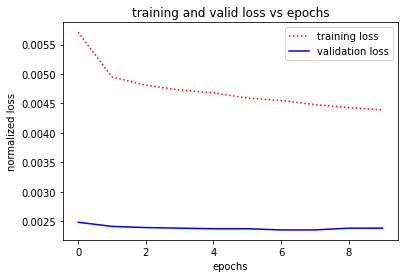

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,train_loss, label="training loss",linestyle='dotted',color='red')
plt.plot( epoch_list,val_loss, label="validation loss",color='blue')

plt.xlabel("epochs")
plt.ylabel("normalized loss")
plt.legend(loc="best")
plt.title('training and valid loss vs epochs')
plt.show()


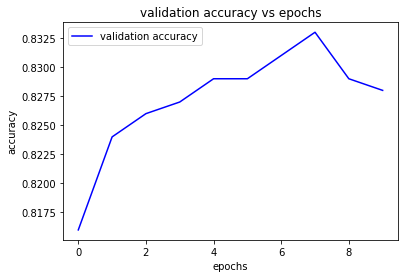

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()


In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()

with torch.no_grad():
     for i in tqdm(range(0,testLen,BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,testLen)


        sent_id= test_seq[i:endIndex].to(device)
        mask   = test_mask[i:endIndex].to(device)

        output=model(sent_id, mask)
      
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(Y_test.tolist(),y_pred))

100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


              precision    recall  f1-score   support

           0       0.85      0.81      0.83      5028
           1       0.82      0.85      0.84      4972

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



# Test bigger hidden unit

In [ ]:
NUM_CLASSES = 2
EMBEDDING_SIZE = 768 #bert embedding length
NUM_FILTERS = 10


class CNN_BertEm(nn.Module):

    def __init__(self, bert,  window_sizes=(1,2,3,5)):

        super(CNN_BertEm, self).__init__() 
        #Bert 
        self.bert=bert

        #CNN                
        self.convs = nn.ModuleList([
              nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
              for window_size in window_sizes
        ])

        self.relu =  nn.ReLU()        
        self.fc1=nn.Linear(NUM_FILTERS * len(window_sizes),500 )
        self.fc2 = nn.Linear(500, 2)
        self.bn = nn.BatchNorm1d(num_features=500)
        self.dropout= nn.Dropout(0.2)
        


    def forward(self, sent_id, attention_mask):

        outputs = bert(sent_id,attention_mask)
        hidden_states = outputs['hidden_states']
        x = torch.stack(hidden_states[-4:]).sum(0)
        # print(x.shape)#torch.Size([1, 50, 768])

        x = torch.unsqueeze(x, 1)
        # print('before CNN',x.shape)#before CNN torch.Size([1, 1, 50, 768])
        #CNN

        xs = []
        for conv in self.convs:
            x2=conv(x)
            x2 = torch.tanh(x2)
            x2 = torch.squeeze(x2, -1)          #you can only squeeze if you know for sure that dimension is 1
            x2 = F.max_pool1d(x2, x2.size(2))   #max_pool1d can only take in 3 dimensional data, thats why you need to squeeze
            xs.append(x2)

        x = torch.cat(xs, 2)        
        x = x.view(x.size(0), -1) #only keep the batch ,(1,40)


        # Feed Forward layer
        x=self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        res = F.softmax(x, dim = 1)

        return res




In [ ]:
%%time

BATCH_SIZE=100

model=CNN_BertEm(bert)
model.to(device)


# model(tseq,tmask)


optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=5

train_loss=[]
val_loss=[]
val_acc=[]

model.train()   #to speicify the training condition


for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'started')
    trainLoss = 0

    
    for i in tqdm(range(0,trainLen,BATCH_SIZE)):

        
        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,trainLen)


        sent_id= train_seq[i:endIndex].to(device)
        mask   = train_mask[i:endIndex].to(device)
        labels = train_y[i:endIndex].to(device)    
        
        output=model(sent_id, mask)

        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    

    trainLoss=round(trainLoss / trainLen,5)
    validLoss,validAcc=getValid()


    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)       

    model.train()  
    
    print('train loss',trainLoss) 
    print()


  0%|          | 1/360 [00:00<00:36,  9.89it/s]

Epoch1 started


  1%|          | 2/360 [00:00<00:32, 11.17it/s]

train loss 0.00561

Epoch2 started


  1%|          | 2/360 [00:00<00:32, 11.07it/s]

train loss 0.00492

Epoch3 started


  1%|          | 2/360 [00:00<00:33, 10.69it/s]

train loss 0.00482

Epoch4 started


  1%|          | 2/360 [00:00<00:33, 10.83it/s]

train loss 0.00474

Epoch5 started


100%|██████████| 360/360 [00:32<00:00, 10.99it/s]


train loss 0.00467

CPU times: user 2min 54s, sys: 1.53 s, total: 2min 56s
Wall time: 2min 58s


In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()

with torch.no_grad():
     for i in tqdm(range(0,testLen,BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,testLen)


        sent_id= test_seq[i:endIndex].to(device)
        mask   = test_mask[i:endIndex].to(device)

        output=model(sent_id, mask)
      
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(Y_test.tolist(),y_pred))

100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


              precision    recall  f1-score   support

           0       0.83      0.82      0.83      5028
           1       0.82      0.83      0.83      4972

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

